# PageRank Performance Benchmarking

This notebook benchmarks performance improvement of running PageRank within cuGraph against NetworkX.

Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 04/04/2019

RAPIDS Versions: 0.6.0

Test Hardware

    GP100 32G, CUDA 9,2
    Dual Intel(R) Xeon(R) CPU E5-2643 v4 @ 3.40GHz
    64GB system memory
    
   

In [1]:
# Import needed libraries
import time
import cugraph
import cudf
import numpy as np
from collections import OrderedDict

In [2]:
# NetworkX libraries
import community
import networkx as nx
from scipy.io import mmread

### Define the test data

In [3]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [4]:
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [5]:
def cugraph_call(M, max_iter, tol, alpha):
    # Device data
    sources = cudf.Series(M.row)
    destinations = cudf.Series(M.col)

    # cugraph Pagerank Call
    G = cugraph.Graph()
    G.add_edge_list(sources, destinations, None)
    
    t1 = time.time()
    df = cugraph.pagerank(G, alpha=alpha, max_iter=max_iter, tol=tol)
    t2 = time.time() - t1
    
    return t2
    

In [6]:
def networkx_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    # Directed NetworkX graph
    Gnx = nx.DiGraph(M)

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}

    # Networkx Pagerank Call
    print('Solving... ')
    t1 = time.time()
    pr = nx.pagerank(Gnx, alpha, z, max_iter, tol)
    t2 = time.time() - t1

    return t2

### Run the benchmarks

In [7]:
perf  = []
names = []

for k,v in data.items():
    M = read_mtx_file(v)
    tr = cugraph_call(M, 100, 0.00001, 0.85)
    tn = networkx_call(M, 100, 0.00001, 0.85)
    speedUp = (tn / tr)
    names.append(k)
    perf.append(speedUp)
    
    print(str(speedUp) + "x fatser =>  cugraph " + str(tr) + " vs " + str(tn))

Reading ./data/preferentialAttachment.mtx...
Solving... 
47.65986240026644x fatser =>  cugraph 0.2634391784667969 vs 12.555474996566772
Reading ./data/caidaRouterLevel.mtx...
Solving... 
161.86431354572542x fatser =>  cugraph 0.10402202606201172 vs 16.837453842163086
Reading ./data/coAuthorsDBLP.mtx...
Solving... 
233.60589966575287x fatser =>  cugraph 0.11106085777282715 vs 25.94447159767151
Reading ./data/dblp-2010.mtx...
Solving... 
145.47996618737153x fatser =>  cugraph 0.14045929908752441 vs 20.434014081954956
Reading ./data/citationCiteseer.mtx...
Solving... 
254.06698572293604x fatser =>  cugraph 0.1185157299041748 vs 30.110934257507324
Reading ./data/coPapersDBLP.mtx...
Solving... 
2150.5247219566577x fatser =>  cugraph 0.15910673141479492 vs 342.1629593372345
Reading ./data/coPapersCiteseer.mtx...
Solving... 
2717.983821733282x fatser =>  cugraph 0.1348874568939209 vs 366.6219255924225
Reading ./data/as-Skitter.mtx...
Solving... 
1653.1430431111003x fatser =>  cugraph 0.176738

In [8]:
### plot the output

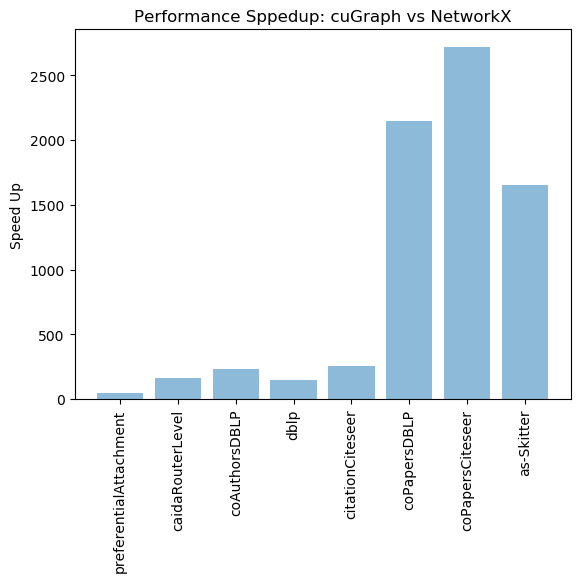

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
y_pos = np.arange(len(names))
 
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.ylabel('Speed Up')
plt.title('Performance Sppedup: cuGraph vs NetworkX')
plt.xticks(rotation=90) 
plt.show()